### Test Encoder

In [1]:
# print(torch.cuda.is_available())
%run tf_helpers.py
import tensorflow as tf

size = 10

unique = unique_set()
X = []
Y = []
X_mask = []
Y_mask = []
network = []
path_sample = []
nodes = []
for i in tqdm(range(size)) :
    file_name = f"Output/5by5_Data{i}"
    x, y, xMask, yMask= generate_xy(file_name, unique)
    X.append(x)
    Y.append(y)
    X_mask.append(xMask)
    Y_mask.append(yMask)

    file = open(file_name, "rb")
    stat = pickle.load(file)
    file.close()
    path_sample.append(stat["data"]["paths_link"])
    nodes.append(stat["data"]["nodes"])

X = tf.stack(X, axis=0)
Y = tf.stack(Y, axis=0)
X_mask = tf.stack(X_mask, axis=0)
Y_mask = tf.stack(Y_mask, axis=0)
print(X.shape, Y.shape, X_mask.shape, Y_mask.shape)
    

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 625, 5) (10, 625, 3) (10, 625, 1) (10, 625, 1)


In [30]:
import pandas as pd

a = pd.DataFrame(X[0].numpy())
a.head()

,0,1,2,3,4
0,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10
1,1.000000e+00,1.000000e+00,1.000000e+00,8.908909e-02,3.012987e-01
2,1.000000e-10,1.000000e-10,1.000000e-10,8.558559e-01,8.727273e-01
3,1.000000e-10,1.000000e-10,1.000000e-10,1.471471e-01,4.727273e-01
4,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10,1.000000e-10


In [12]:
%run tf_attention.py

encoder = EncoderLayer(5,64,8,0.1,0.01)
encoder_output = encoder(X, X_mask)
print(encoder_output.shape)
pd.DataFrame(encoder_output[0].numpy()).head()

(80, 625, 625)
(80, 625, 625)
(10, 625, 5)
(10, 625, 5)


,0,1,2,3,4
0,-1.290896,-0.074001,-0.790971,1.513015,0.642853
1,0.681227,1.264723,0.403206,-1.089264,-1.259893
2,-1.155252,-0.226850,-0.947829,1.139854,1.190077
3,-1.178328,-0.014503,-1.001674,0.780985,1.413521
4,-1.290896,-0.074001,-0.790971,1.513015,0.642853


### Test Decoder

In [18]:
%run tf_attention.py
decoder = Decoder(output_dim=3, d_model=512, N=4, heads=8, dropout=0.1, reg_factor=0.01)
decoder_out = decoder(Y,encoder_output, X_mask, Y_mask)
print(decoder_out.shape)
pd.DataFrame(decoder_out[0].numpy()).head()

(10, 625, 3)


,0,1,2
0,0.900061,0.493855,-1.393916
1,1.366686,-0.995798,-0.370889
2,1.397574,-0.882067,-0.515507
3,1.378088,-0.961360,-0.416728
4,0.900061,0.493855,-1.393916


### Test Transformer

In [6]:
%run tf_attention.py
import pandas as pd

transformer = Transformer(5,3,64,2,8,0.1, 0.01)
transformer.train()
out = transformer(X, Y, X_mask, Y_mask, training=True)
pd.DataFrame(out[0].numpy()).head()

,0,1,2
0,-0.922675,-0.468371,1.091118
1,-1.013945,-0.534928,1.057100
2,-0.704900,-0.312890,1.148928
3,-1.348602,-0.789411,0.859096
4,-1.375814,-0.811174,0.835488


### Extract OD demand and path set (X and Y)
X: OD demand, graph (link feature), path, link-path adj \
Y: path flow

In [2]:
%run tf_attention.py
%run tf_helpers.py 
%run Parameters.py
param = Params()

class Dataset:
    def __init__(self, size, start_from=0):
        self.path_encoded = unique_set()  # Get path encode dictionary
        self.X = []
        self.Y = []
        self.X_mask = []
        self.Y_mask = []

        for i in tqdm(range(size)):
            file_name = ''.join([param.base_path, str(start_from+i)])
            x, y, xMask, yMask = generate_xy(file_name, self.path_encoded)
            self.X.append(x)
            self.Y.append(y)
            self.X_mask.append(xMask)
            self.Y_mask.append(yMask)
        
        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)
        self.X_mask = tf.stack(self.X_mask, axis=0)
        self.Y_mask = tf.stack(self.Y_mask, axis=0)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.X_mask[idx], self.Y_mask[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y, self.X_mask, self.Y_mask))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset 
    

In [3]:
# %run helpers.py
%run Parameters.py
param = Params()

d_model_list = []
N_list = []
learning = []
epochs_list = []
training_time = []

train_dataset = Dataset(param.train_size)
train_data_loader = train_dataset.to_tf_dataset(param.batch_size)

val_dataset = Dataset(param.val_size, start_from=param.train_size)
val_data_loader = val_dataset.to_tf_dataset(param.batch_size)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### TRY TRAINING AND VALIDATING

In [4]:
from tensorflow.keras.optimizers import Adam
import time

%run tf_attention.py
%run Parameters.py
param = Params()

model = Transformer(input_dim=param.input_dim, output_dim=param.output_dim, 
                    d_model=param.d_model, N=param.N, heads=param.heads, 
                    dropout=param.drop_out, reg_factor=param.reg_factor)
optimizer = Adam(learning_rate=param.lr)

start = time.time()
model, train_loss, val_loss = model.compile(train_data_loader, val_data_loader, optimizer, 
                                            param.loss_fn, param.epochs, param.device)
end = time.time()
train_time = end-start

training_time.append(train_time)
d_model_list.append(param.d_model)
N_list.append(param.N)
epochs_list.append(param.epochs)

  0%|          | 0/100 [00:00<?, ?epoch/s]

: 

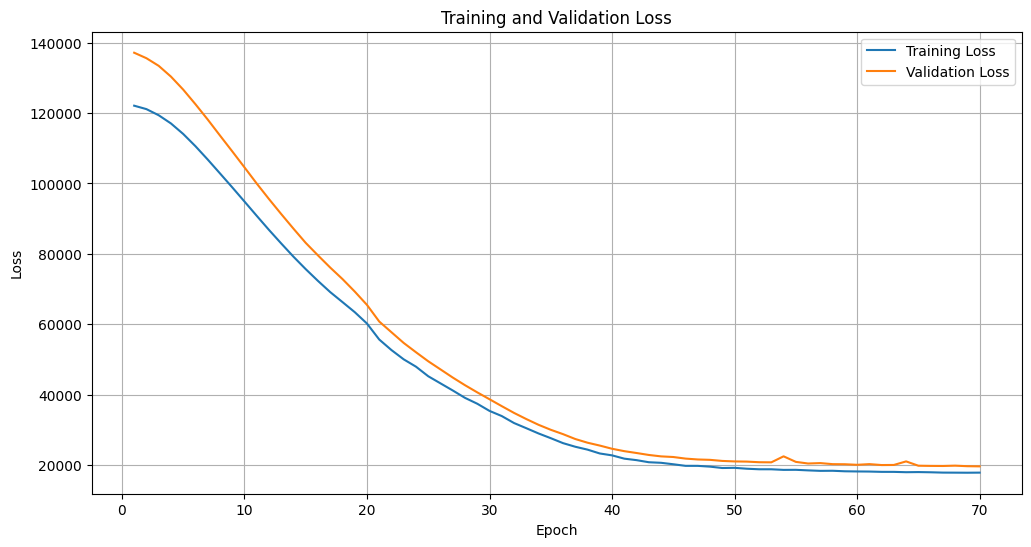

In [21]:
# 1st try, 70 epochs, lr 0.002, d-model 128, N 2
plot_loss(train_loss, val_loss, epochs)

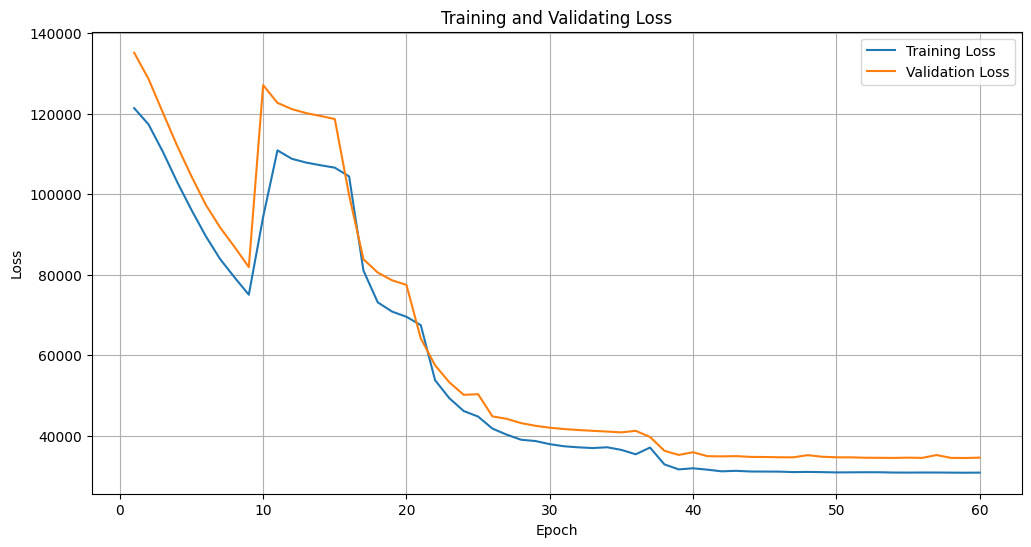

In [25]:
# 2nd try: 60 epochs, lr 0.004, time 37m
plot_loss(train_loss, val_loss, epochs)

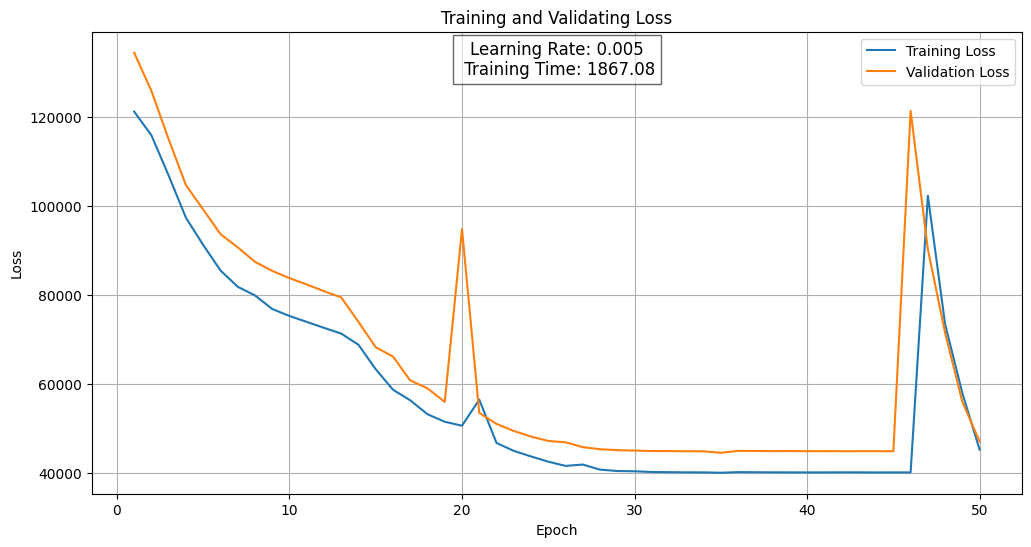

In [37]:
import time
# 3rd try: 50 epochs, lr 0.005, time 
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time)


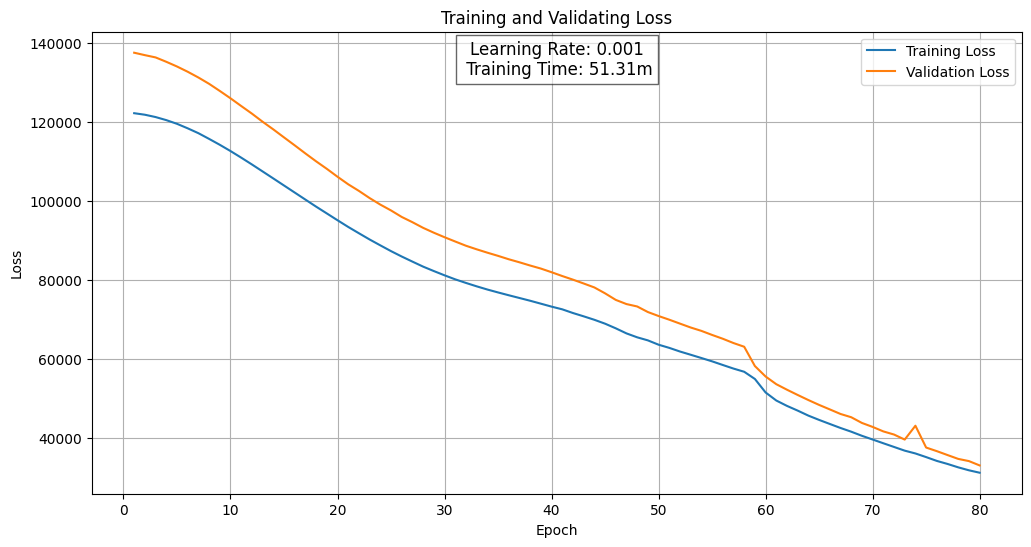

In [41]:

# 4th try: add l2 norm to the last layer of Transformer
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time)

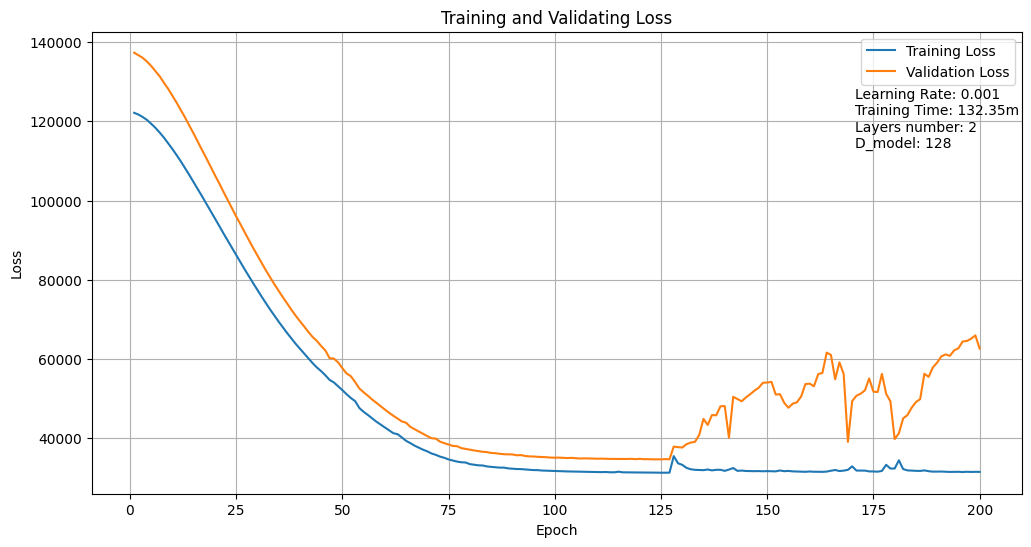

In [82]:
# !pip install plotly
%run tf_helpers.py
# 5th: 
plot_loss(train_loss, val_loss, epochs, learning_rate, train_time, N, d_model)

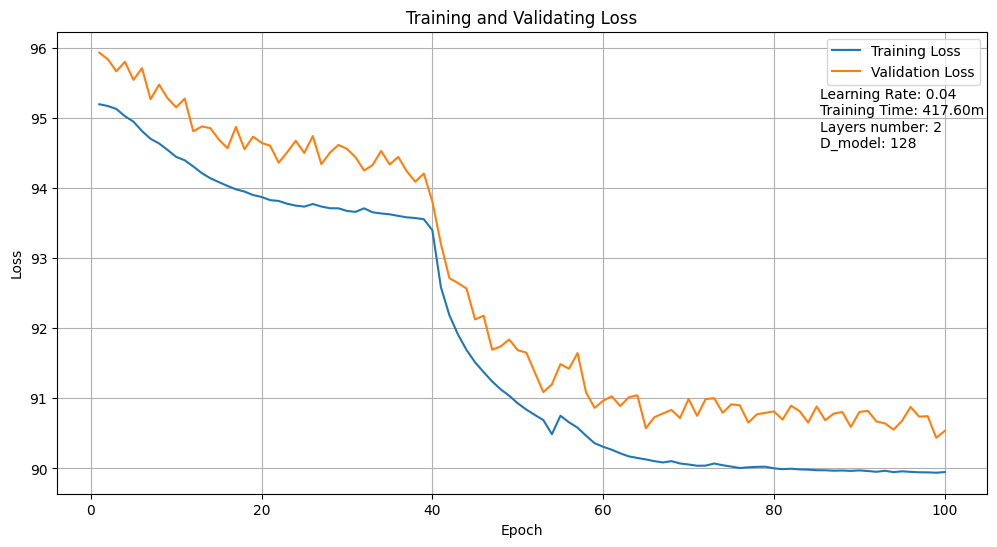

In [7]:
# ver 5:
plot_loss(train_loss, val_loss, param.epochs, param.lr, train_time, param.N, param.d_model)